Homework #2- Due: 3/20/25
conda activate columnar_env
jupyter lab --no-browser --port 8084
open new terminal, in main: ssh -L 8084:localhost:8084 lwills@vmlab.niu.edu
open link :)

In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = uproot.open("/lstr/sahara/act/data/DAOD_PHYSLITE.37621365._000015.pool.root.1")
tree = file["CollectionTree;1"]

In [3]:
#tree.keys()

In [4]:
x = len(tree) # fix me
print("Number of branches:", x)

Number of branches: 1360


In [5]:
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.charge", "AnalysisElectronsAuxDyn.pt","AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi","AnalysisElectronsAuxDyn.m"])
Muons = tree.arrays([ "AnalysisMuonsAuxDyn.charge", "AnalysisMuonsAuxDyn.pt","AnalysisMuonsAuxDyn.eta", "AnalysisMuonsAuxDyn.phi"]) # fix me

In [7]:
print(len(Muons))

200000


In [8]:
e = ak.zip({
    "pt" : Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta" : Electrons["AnalysisElectronsAuxDyn.eta"],
    "phi" : Electrons["AnalysisElectronsAuxDyn.phi"],
    "mass" : Electrons["AnalysisElectronsAuxDyn.m"],
    "charge" : Electrons["AnalysisElectronsAuxDyn.charge"]
})
mu = ak.zip({
    "pt" : Muons["AnalysisMuonsAuxDyn.pt"],
    "eta" : Muons["AnalysisMuonsAuxDyn.eta"],
    "phi" : Muons["AnalysisMuonsAuxDyn.phi"],
    "mass" : np.full(200000, 0),
    "charge" : Muons["AnalysisMuonsAuxDyn.charge"]
})

In [9]:
num_e = ak.sum(ak.num(e.pt)) # fix me
num_mu = ak.sum(ak.num(mu.pt)) # fix me
print("Total number of electrons: ", num_e)
print("Total number of muons: ", num_mu)
#num_lep = ak.sum(ak.num(lep.pt))
#print("Total number of leptons", num_lep)

Total number of electrons:  54852
Total number of muons:  397347


In [10]:
e_cut = (e.pt>25000) & (ak.num(e.charge) ==2 ) & (ak.sum(e.charge, axis = 1) == 0)
cleaned_e = e[e_cut]
# check 
filtered_electrons = ak.sum(ak.num(cleaned_e)) 
print("Number of electrons that passed selection:", filtered_electrons)

Number of electrons that passed selection: 837


In [11]:
#Need to get rid off all of the events after the cut that are less than 2 electrons now
cut_cut_clean = ak.num(cleaned_e) == 2
clean_clean = cleaned_e[cut_cut_clean]
super_filtered_electrons = ak.sum(ak.num(clean_clean))
print(super_filtered_electrons)

108


In [12]:
lengths_e = ak.num(clean_clean)
indices_e = ak.where(lengths_e == 2)[0].tolist()
#indices

In [13]:
mu_cut = (mu.pt>25000) & (ak.num(mu.charge) ==2 ) & (ak.sum(mu.charge, axis = 1) == 0)
cleaned_mu = mu[mu_cut]
# check 
filtered_muons = ak.sum(ak.num(cleaned_mu)) 
print("Number of electrons that passed selection:", filtered_muons)

Number of electrons that passed selection: 194606


In [14]:
cut_cut_clean_mu = ak.num(cleaned_mu) == 2
clean_clean_mu = cleaned_mu[cut_cut_clean_mu]
super_filtered_muons = ak.sum(ak.num(clean_clean_mu))
print(super_filtered_muons)

154542


In [15]:
lengths_mu = ak.num(clean_clean_mu)
indices_mu = ak.where(lengths_mu == 2)[0].tolist()

In [16]:
def Px(pt, phi):
    return pt*np.cos(phi)

def Py(pt,phi):
    return pt*np.sin(phi)

def Pz(pt,eta):
    return pt*np.sinh(eta)

def E(pt, eta, m):
    return np.sqrt(pt**2 * np.cosh(eta)**2 + m**2)

def Em(pt, eta):
    return np.sqrt(pt**2 * np.cosh(eta)**2 + 0)

e_px = Px(clean_clean.pt,clean_clean.phi)
e_py = Py(clean_clean.pt,clean_clean.phi)
e_pz = Pz(clean_clean.pt,clean_clean.eta)
e_E = E(clean_clean.pt,clean_clean.eta,clean_clean.mass)
mu_px = Px(clean_clean_mu.pt, clean_clean_mu.phi)
mu_py = Py(clean_clean_mu.pt, clean_clean_mu.phi)
mu_pz = Pz(clean_clean_mu.pt, clean_clean_mu.eta)
mu_E = Em(clean_clean_mu.pt, clean_clean_mu.eta)

In [17]:
def calc_invm_e(p1, p2):
    sumpx = Px(p1.pt, p1.phi)+Px(p2.pt, p2.phi)
    sumpy = Py(p1.pt, p1.phi) + Py(p2.pt, p2.phi)
    sumpz = Pz(p1.pt, p1.eta) + Pz(p2.pt, p2.eta) 
    sumE = E(p1.pt, p1.eta, p1.mass) + E(p2.pt, p2.eta, p2.mass)
    
    invm = np.sqrt(sumE**2-sumpx**2 - sumpy**2 - sumpz**2) # fix me
    return invm/1000.0 # in GeV

In [18]:
def calc_invm_mu(p1, p2):
    sumpx = Px(p1.pt, p1.phi)+Px(p2.pt, p2.phi)
    sumpy = Py(p1.pt, p1.phi) + Py(p2.pt, p2.phi)
    sumpz = Pz(p1.pt, p1.eta) + Pz(p2.pt, p2.eta) 
    sumEm = Em(p1.pt, p1.eta) + Em(p2.pt, p2.eta)
    
    invm_mu = np.sqrt(sumEm**2-sumpx**2 - sumpy**2 - sumpz**2) # fix me
    return invm_mu/1000.0 # in GeV

In [19]:
invariant_masses_m = [calc_invm_mu(event[0], event[1]) for event in clean_clean_mu]

In [20]:
invariant_masses_e = [calc_invm_e(event[0], event[1]) for event in clean_clean]

In [21]:
invariant_masses = ak.concatenate([invariant_masses_m, invariant_masses_e])

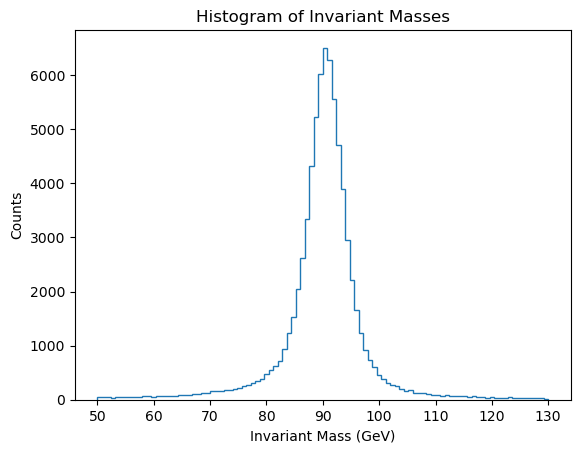

In [22]:
hist = plt.hist(invariant_masses, bins=100, range = (50,130), histtype = 'step', )
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Counts')
plt.title('Histogram of Invariant Masses')
plt.show()
#z_mass = invariant_masses(np.argmax[hist, axis==0])
#print(z_mass)

In [30]:
z_mass = invariant_masses[np.argmax(np.histogram(invariant_masses, bins = 100, range = (50,130))[0])]
print( "Z_mass in GeV:", z_mass)

Z_mass in GeV: 94.80464517722325


Problem #2- select events that have at least one lepton, pt> 30GeV, and abs{eta}<2.1. Also  at least four jets all with pt>25 GeV, and abs(eta)<2.4. See how many events were selected, plot distribution plots to check selection. 
- calculate btag dscriminate of the selected jets
- 'b-tagged' if discriminant > 2.456. Only select events with 2+ b-tagged jets, plot distributions.
- /lstr/sahara/act/data/DAOD_PHYSLITE.37620644._000012.pool.root.1

In [2]:
top_file = uproot.open('/lstr/sahara/act/data/DAOD_PHYSLITE.37620644._000012.pool.root.1')
tree_top = top_file['CollectionTree;1']

In [10]:
#tree_top.keys()

In [3]:
Electrons = tree_top.arrays(["AnalysisElectronsAuxDyn.charge", "AnalysisElectronsAuxDyn.pt","AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi","AnalysisElectronsAuxDyn.m"])
Muons = tree_top.arrays([ "AnalysisMuonsAuxDyn.charge", "AnalysisMuonsAuxDyn.pt","AnalysisMuonsAuxDyn.eta", "AnalysisMuonsAuxDyn.phi"])
Jets = tree_top.arrays([ "AnalysisJetsAuxDyn.pt", "AnalysisJetsAuxDyn.eta", "AnalysisJetsAuxDyn.phi", "AnalysisJetsAuxDyn.m" , "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb", "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc", "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu"])

In [4]:
electrons = ak.zip({
    "pt" : Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta" : Electrons["AnalysisElectronsAuxDyn.eta"],
    "phi" : Electrons["AnalysisElectronsAuxDyn.phi"],
    "mass" : Electrons["AnalysisElectronsAuxDyn.m"],
    "charge" : Electrons["AnalysisElectronsAuxDyn.charge"],
})
muons = ak.zip({
    "pt" : Muons["AnalysisMuonsAuxDyn.pt"],
    "eta" : Muons["AnalysisMuonsAuxDyn.eta"],
    "phi" : Muons["AnalysisMuonsAuxDyn.phi"],
    "mass" : np.full(160000, 0),
    "charge" : Muons["AnalysisMuonsAuxDyn.charge"]
})    
jets = ak.zip({
    "pt" : Jets["AnalysisJetsAuxDyn.pt"],
    "eta" : Jets["AnalysisJetsAuxDyn.eta"],
    "phi" : Jets["AnalysisJetsAuxDyn.phi"],
    "mass" : Jets["AnalysisJetsAuxDyn.m"],
    "pb" : Jets["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb"],
    "pc" : Jets["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc"],
    "pu" : Jets["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu"],
    "fc" : np.full(160000, 0.018)
})

In [5]:
electrons_filt = (abs(electrons.eta) < 2.1) & (electrons.pt >30000)
muons_filt = (abs(muons.eta) < 2.1) & (muons.pt > 30000)
jet_filt = (abs(jets.eta) <2.4) & (jets.pt > 25000)

In [6]:
cleaned_electrons = electrons[electrons_filt]
cleaned_muons = muons[muons_filt]
#I want events where at least one lepton remains after the pt and eta cut
n_electrons = ak.num(cleaned_electrons)
n_muons = ak.num(cleaned_muons)
lepton_mask = (n_electrons + n_muons) > 0 

In [7]:
cleaned_jets = ak.all(jet_filt, axis=1)
jet_mask = (ak.num(jets) >= 4) & cleaned_jets

In [8]:
event_mask = (lepton_mask) & (jet_mask)
filtered_electrons = electrons[event_mask]
filtered_muons = muons[event_mask]
filtered_jets = jets[event_mask]
print(len(filtered_jets))
#print(ak.sum(ak.num(filtered_electrons)))
#print(ak.sum(ak.num(filtered_muons)))
#print(ak.sum(ak.num(filtered_jets)))

1925


In [9]:
jet_pt = ak.flatten(jets.pt)
print('Total number of original Jets:', len(jet_pt))
jet_eta = ak.flatten(jets.eta)
filter_jet_pt = ak.flatten(filtered_jets.pt)
print('Total number of jets after being filtered:', len(filter_jet_pt))
filter_jet_eta = ak.flatten(filtered_jets.eta)

Total number of original Jets: 1292155
Total number of jets after being filtered: 9724


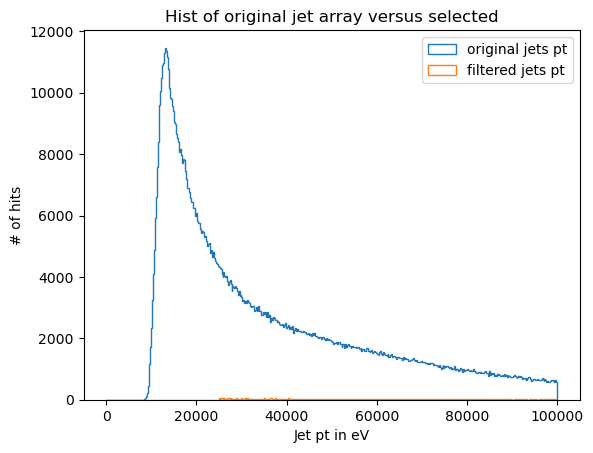

In [10]:
plt.hist(jet_pt, bins = 500, range = (0, 0.1e6), histtype = 'step', label = 'original jets pt')
plt.hist(filter_jet_pt, bins = 500, range = (0, 0.1e6), histtype = 'step', label = 'filtered jets pt')
plt.xlabel('Jet pt in eV')
plt.ylabel('# of hits')
plt.legend()
plt.title('Hist of original jet array versus selected')
plt.show()
# Need to fix this to show that the 

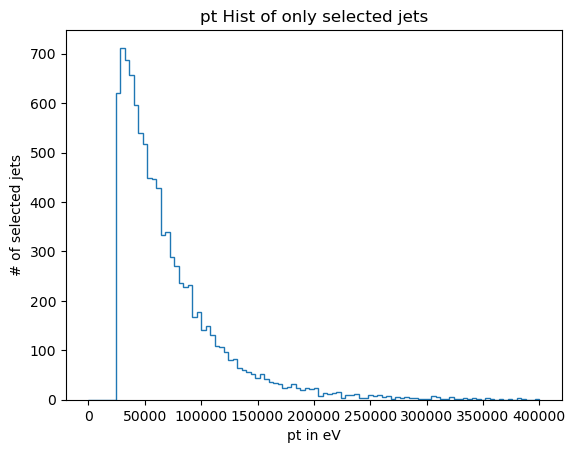

In [11]:
#Better look at just selected jets:
plt.hist(filter_jet_pt, bins = 100, range = (0, 4e5), histtype = 'step')
plt.xlabel('pt in eV')
plt.ylabel('# of selected jets')
plt.title('pt Hist of only selected jets')
plt.show()

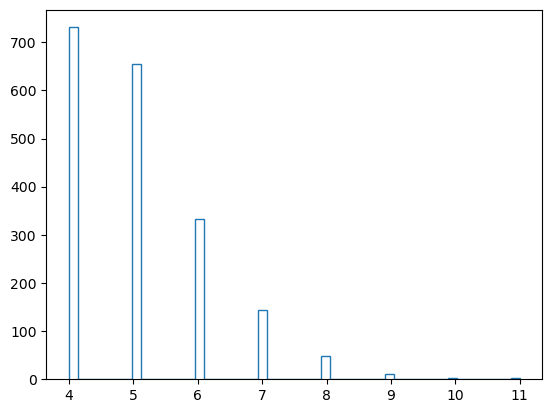

In [12]:
plt.hist(ak.num(filtered_jets.pt), bins = 50, histtype = 'step')
#plt.hist(ak.num(jets.pt), bins = 50, histtype = 'step')
plt.show()

From these histograms we can see that the cut worked, all the selected events have four or more jets and each jet has a .pt of more than 25,000 eV. Neato Mostquito. Could make plots of .eta as well as the number of leptons, but you get the idea. 

Part B- Calculate the btag descriminate for the filtered events

In [17]:
# need to index like we did in part a: 
filtered_jets_array = ak.num(filtered_jets)
indices_filtered_jets = ak.where(filtered_jets_array > 3)[0].tolist()
print(len(indices_filtered_jets))

1925


In [13]:
def calc_tbag_den(pc, pu, fc):
    return fc*pc+(1-fc)*pu

In [14]:
def calc_tbag(jet):
    return np.log(jet.pb / calc_tbag_den(jet.pc, jet.pu, jet.fc))

In [15]:
# need to iterate over each jet in each event, and then iterate over all of the events in filtered_jets
tbag = ak.Array([[calc_tbag(jet) for jet in event] for event in filtered_jets]) 

In [16]:
#check
print(len(tbag))
print(filtered_jets.phi[5])
print(tbag[5])
x = np.log(filtered_jets.pb[5] / (filtered_jets.fc[5] * filtered_jets.pc[5] + (1 - filtered_jets.fc[5]) * filtered_jets.pu[5]))
print(x)
# yay same number of jets, and looks like the calculation is correct, and it has the same length as indices_filtered_jets

1925
[1.6, -1.64, -0.907, 0.393]
[6.54, -3.74, -4.4, 9.71]
[6.54, -3.74, -4.4, 9.71]


Event is considered btag if descriminate is above threshold > 2.456, select all events that have at least two jets that are above this threshold. Make distributions and such

In [28]:
tbag_array = ak.flatten(tbag)

In [18]:
filtered_tbag = ak.Array([jet [jet>2.456] for jet in tbag])

In [32]:
cleaned = ak.num(filtered_tbag) >= 2
cleaned_tbag = tbag[cleaned]
print(len(cleaned_tbag))

1093


In [33]:
cleaned_tbag_array = ak.flatten(cleaned_tbag)

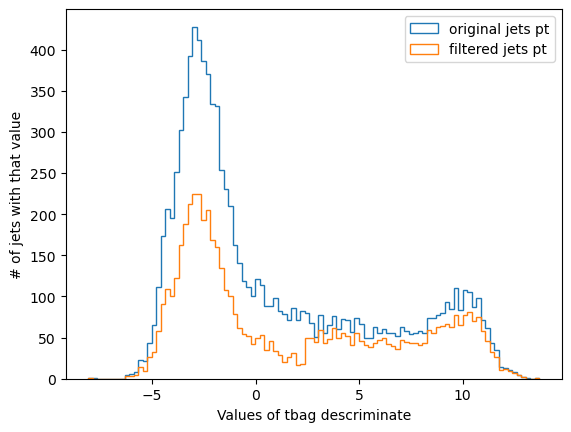

In [34]:
# And then need to plot distribution
plt.hist(tbag_array, bins = 100, histtype = 'step', label = 'Previously selected events')
plt.hist(cleaned_tbag_array, bins = 100, histtype = 'step', label = 'Events with => 2 btagged jets')
plt.xlabel('Values of tbag descriminate')
plt.ylabel('# of jets with that value')
plt.legend()
plt.show()

Hmmm not exactly sure what plots ar useful? The directions said to select events with at least 2 btag jets, but that means that events can still include jets that a tbag less than 2.546, so a hist of all the tbag descrimitae values would not be very useful. 

Part 3- ttbar sample /lstr/sahara/act/data/TTto2L2Nu_NanoAODv12-130x_mcRun3_13p6TeV_powheg-pythia.root
Calculate the efficiency of the HLT_Mu8 trigger (ration of # of events passing the trigger versus all events) for events with 1 muons as a fraction of muon.pt. At what pt. does the trigger turn on (HLT_mu8 = true)
Do it again but for events with two muons. 

In [43]:
ttbar_file = uproot.open("/lstr/sahara/act/data/TTto2L2Nu_NanoAODv12-130x_mcRun3_13p6TeV_powheg-pythia.root")

In [44]:
ttbar_file.keys()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

In [45]:
events = ttbar_file['Events;1']

In [46]:
for key in events.keys():
    if "muons" in key:
        print(key)

In [47]:
#trigger = events.arrays(['HLT_Mu8'])
muons = events.arrays(['Muon_pt', 'Muon_charge', 'HLT_Mu8'])
#print(len(trigger))
print(len(muons))

262125


In [48]:
mu = ak.zip({
    "pt" : muons["Muon_pt"],
    "charge" : muons["Muon_charge"],
    "trig_val" : muons["HLT_Mu8"]
})
#mu_trig = ak.zip({
#    "value" : trigger["HLT_Mu8"]
#})

In [49]:
mu_1 = (ak.num(mu.charge) ==1) & (mu.trig_val == True)
mu_select = mu[mu_1]
print('length of original:', len(mu_1))
cut_mu1 = ak.num(mu_select) ==1
only_1_mu = mu_select[cut_mu1]
print('length of cut:', len(only_1_mu))

length of original: 262125
length of cut: 76132


In [116]:
min = np.argmin(only_1_mu.pt)
only_1_mu.pt[min]

<Array [3] type='1 * float32'>

In [62]:
mu_1_false = (ak.num(mu.charge) ==1) & (mu.trig_val == False)
mu_select_false = mu[mu_1_false]
print('length of original:', len(mu_1))
cut_mu1_false = ak.num(mu_select_false) ==1
only_1_mu_false = mu_select_false[cut_mu1_false]
print('length of cut:', len(only_1_mu_false))

length of original: 262125
length of cut: 25778


In [66]:
max_false = np.argmax(only_1_mu_false.pt)
max_false
only_1_mu_false[2014]

<Array [{pt: 2.21e+04, charge: -1, ...}] type='1 * {pt: float32, charge: in...'>

well, my idea was that if the trigger is turning on for a cerain value, it would be between the minimum pt value of events where the trigger = True and the maximum value where the trigger = False. That is clearly not the case, I do not know what value the trigger turns on for. 

In [69]:
print(only_1_mu_false.pt[4], only_1_mu_false.pt[364], only_1_mu_false.pt[967], only_1_mu_false.pt[1157], only_1_mu_false.pt[1840])
print(only_1_mu.pt[17], only_1_mu.pt[1354], only_1_mu.pt[8271], only_1_mu.pt[11536], only_1_mu.pt[26352])

[7.49] [3.99] [4.21] [3.86] [23.2]
[41.6] [67.8] [19] [9.48] [15.2]


In [104]:
#what about an average? 
avg = np.average(only_1_mu.pt)
avg

46.529972

In [71]:
mu_1_true_flat_pt = ak.flatten(only_1_mu.pt, axis = None)
print(len(mu_1_true_flat_pt))
muon_flat_pt = ak.flatten(mu.pt, axis = None)

76132


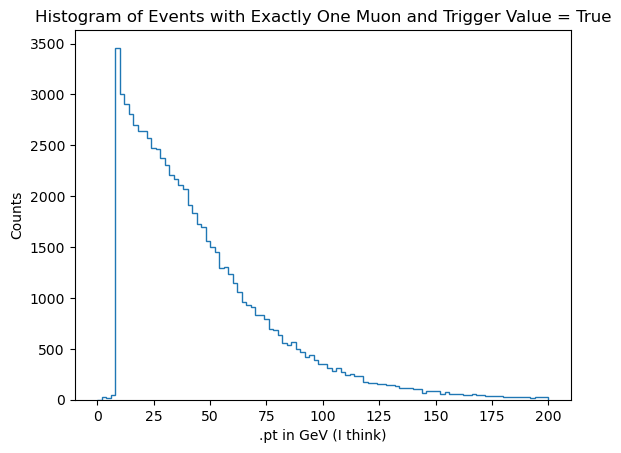

In [72]:
plt.hist(mu_1_true_flat_pt, bins = 100, range = (0, 200), histtype = 'step')
plt.xlabel('.pt in GeV (I think)')
plt.ylabel('Counts')
plt.title('Histogram of Events with Exactly One Muon and Trigger Value = True')
plt.show()

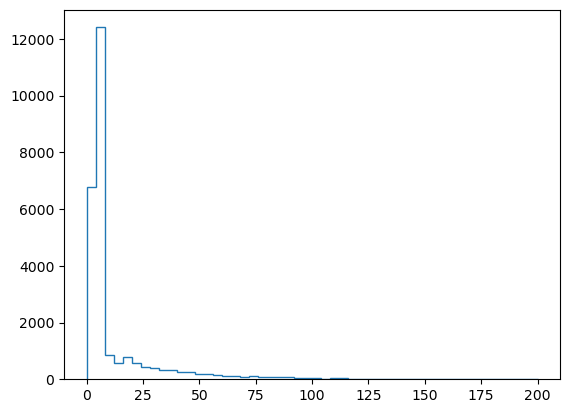

In [78]:
# just to see: 
#mu_1_false_flat_pt = ak.flatten(only_1_mu_false.pt, axis = None)
#print(len(mu_1_false_flat_pt))
plt.hist(only_1_mu_false.pt, bins = 50, range = (0,200), histtype = 'step')
plt.show()

In [79]:
#Need to calculate the efficiency: 
num_bins = 100
pt_range = 0, 200
selected_counts, bin_edges = np.histogram(mu_1_true_flat_pt, bins = num_bins, range = pt_range)
total_counts, _ = np.histogram(muon_flat_pt, bins = bin_edges)

In [80]:
selected_counts_array = np.asarray(selected_counts)
print(len(selected_counts_array)) #quick check yay it is 100 and the values do mostly make sense
total_counts_array = np.asarray(total_counts)

100


In [81]:
efficiency = np.divide(
    selected_counts_array,
    total_counts_array,
    out=np.zeros_like(selected_counts_array, dtype=float),
    where=total_counts_array != 0
)
print(len(efficiency))

100


In [99]:
#efficiency

In [82]:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

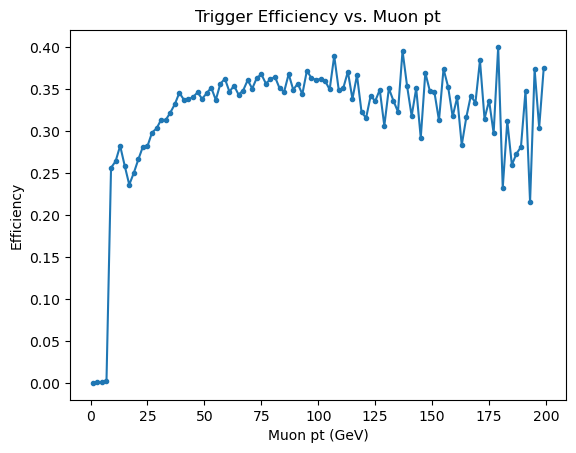

In [103]:
plt.plot(bin_centers, efficiency, marker='.', linestyle='-', label="Trigger Efficiency")
plt.xlabel("Muon pt (GeV)")
plt.ylabel("Efficiency")
plt.title("Trigger Efficiency vs. Muon pt")
plt.show()

In [85]:
mu_2 = (ak.num(mu.charge) ==2) & (mu.trig_val == True)
mu_select_2 = mu[mu_2]
print('length of original:', len(mu_2))
cut_mu2 = ak.num(mu_select_2) ==2
only_2_mu = mu_select_2[cut_mu2]
print('length of cut:', len(only_2_mu))

length of original: 262125
length of cut: 54587


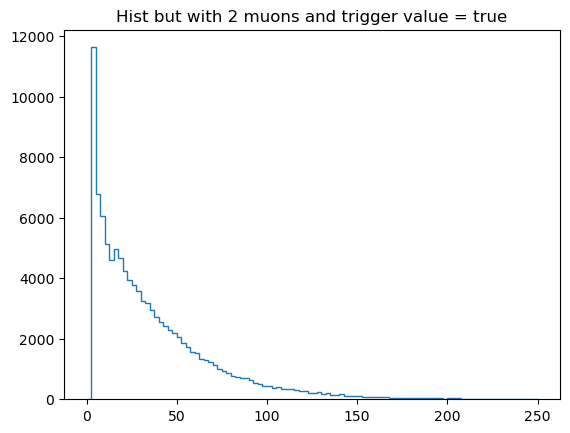

In [93]:
mu_2_true_pt = ak.flatten(only_2_mu.pt)
plt.hist(mu_2_true_pt, bins = 100, range = (0,250), histtype = 'step')
plt.title('Hist but with 2 muons and trigger value = true')
plt.show()

In [95]:
num_bins_2 = 200
pt_range_2 = 0, 250
selected_counts_2, bin_edges_2 = np.histogram(mu_2_true_pt, bins = num_bins_2, range = pt_range_2)
total_counts_2, _ = np.histogram(muon_flat_pt, bins = bin_edges_2)
selected_counts_array_2 = np.asarray(selected_counts_2)
total_counts_array_2 = np.asarray(total_counts_2)

In [97]:
efficiency_2 = np.divide(
    selected_counts_array_2,
    total_counts_array_2,
    out=np.zeros_like(selected_counts_array_2, dtype=float),
    where=total_counts_array_2 != 0
)
bin_centers_2 = 0.5 * (bin_edges_2[:-1] + bin_edges_2[1:])

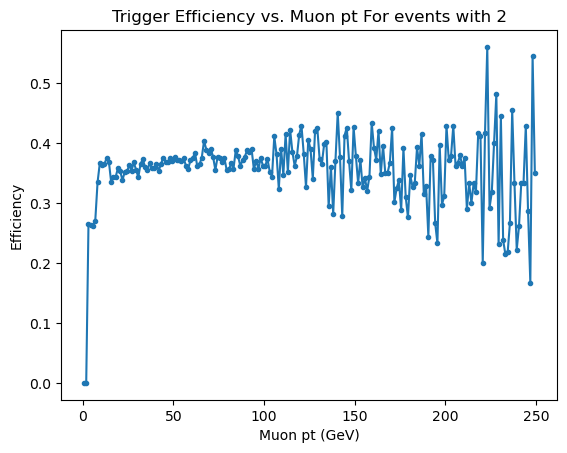

In [101]:
plt.plot(bin_centers_2, efficiency_2, marker='.', linestyle='-', label="Trigger Efficiency")
plt.xlabel("Muon pt (GeV)")
plt.ylabel("Efficiency")
plt.title("Trigger Efficiency vs. Muon pt For events with 2")
plt.show()

Comments: For both cases, the efficiency varies a lot more as the .pt increases. They both seem to oscillate around an efficiency of about ~0.37, but the 2 muon case ends up oscillating more at reaching higher values as .pt increases. I cannot find any coorelation between the .pt measurement and the values of the trigger. Based off of the name though I would assume that it is sorting between muons with more or less than 8 GeV, but my analysis does not reflect that. 
